In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pk
import math
from math import sqrt
import random
import scipy
from scipy.stats import t, norm
from scipy.optimize import least_squares

gas_const = scipy.constants.gas_constant
T_ref = 278
N_MONTHS = 29
N_SIMULATION = 999
DESIRED_TEMP = 298

In [2]:
"""
Single First Order
"""
def single_rate_constant(T, kT_ref, E_a):
    e = math.e**(((-E_a)/gas_const)*((1/T) - (1/T_ref)))
    return (kT_ref * e)

def A_single (params, t,T):
    k = single_rate_constant(T, params[1], params[2])
    e = math.e**((-1)* k *t)
    return (params[0] * e)

def B_single(params, t, T, B_0):
    A = A_single(params, t, T)
    return (B_0 + params[0] - A)

"""
Parallel First Order
"""
def parallel_rate_constant(T, kT_refX, E_aX):
    e = math.e**(((-E_aX)/gas_const)*((1/T) - (1/T_ref)))
    return (kT_refX * e)

def A_parallel(params, t, T):
    k_b = parallel_rate_constant(T, params[2], params[4])
    k_c = parallel_rate_constant(T, params[3], params[5])
    e = math.e**((-1)*( k_b + k_c )*t)
    return (params[0] * e)

def B_parallel(params, t, T):
    k_b = parallel_rate_constant(T, params[2], params[4])
    k_c = parallel_rate_constant(T, params[3], params[5])
    e = math.e**((-1)*(k_b + k_c) * t)
    total_k = params[2] + params[3]
    x = params[0] * (params[2] / total_k) * (1 - e)
    return (x - params[1])
    
def C_parallel(params, t, T):
    k_b = parallel_rate_constant(T, params[2], params[4])
    k_c = parallel_rate_constant(T, params[3], params[5])
    e = math.e**((-1)*(k_b + k_c) * t)
    total_k = params[2] + params[3]
    x = params[0] * (params[3] / total_k) * (1 - e)
    # [C]_0 = 100 - ([A]_0 + [B]_0
    return (x - (100 - (params[0] + params[1])))

"""
Single N-th Order
"""
def A_n_single(params, t, T):
    k = single_rate_constant(T, params[1], params[2])
    A = (params[0] ** (1 - params[3])) - k * t * (1-params[3])
    return (A ** (1/(1-params[3])))
            
def B_n_single(params, t, T):
    A = A_n_single(params, t, T)
    return (100 - A)

In [3]:
with open('results.pk', 'rb') as fp:
    results = pk.load(fp)

In [4]:
result_single_first, result_single_n, result_parallel_first = results

In [5]:
results

(     message: `xtol` termination condition is satisfied.
      success: True
       status: 3
          fun: [ 1.676e-01]
            x: [ 9.156e+01  2.546e-04  2.421e+02]
         cost: 0.014039507901694373
          jac: [[ 2.695e-05  9.623e+00 -2.416e-06]]
         grad: [ 4.516e-06  1.613e+00 -4.048e-07]
   optimality: 0.0004106246749842487
  active_mask: [0 0 0]
         nfev: 17
         njev: 6,
      message: `xtol` termination condition is satisfied.
      success: True
       status: 3
          fun: [ 1.589e-01]
            x: [ 9.996e+01  1.311e-02  1.200e+02  4.197e-04]
         cost: 0.0126281043247941
          jac: [[-2.019e-03  3.853e-04 -1.328e-06  1.908e-05]]
         grad: [-3.209e-04  6.123e-05 -2.110e-07  3.031e-06]
   optimality: 1.3168100503164739e-05
  active_mask: [0 0 0 0]
         nfev: 167
         njev: 124,
      message: The maximum number of function evaluations is exceeded.
      success: False
       status: 0
          fun: [ 1.305e+01]
            

In [19]:
rmse_single_first = sqrt(result_single_first.fun[0]/(11 - 3))
rmse_single_n = sqrt(result_single_n.fun[0]/(11 - 4))
rmse_parallel_first = sqrt(result_parallel_first.fun[0]/(11 - 6))

params_single_first = result_single_first.x
params_single_n = result_single_n.x
params_parallel_first = result_parallel_first.x

## SEEMS LIKE WE DON'T NEED THE PREVIOUS PARAMETERS

In [7]:
df = pd.read_csv('sample.csv')
df['[B]'] = df['[B] HMW'] + df['[C] LMW']
df.drop(columns={'Temp (°C)', '[A] Monomer (parallel)'}, inplace = True)
df.rename(columns={'[B] HMW': '[C] LMW'}, inplace=True)
df.rename(columns={'[C] LMW': '[B] HMW'}, inplace=True)
df.rename(columns={'[A] Monomer (single)': '[A]'}, inplace=True)



t0_df = df[df['Time (months)'] == 0]
t1_df = df[(df['Time (months)'] == 1) & (df['Temp (K)'].isin([278.15, 298.15, 313.15]))]
t3_df = df[(df['Time (months)'] == 3) & (df['Temp (K)'].isin([278.15, 298.15, 313.15]))]
t6_df = df[(df['Time (months)'] == 6) & (df['Temp (K)'].isin([278.15, 298.15]))]
df_train = pd.concat([t0_df, t1_df, t3_df, t6_df], ignore_index=True)

df_test = df[df['Time (months)'] > 6]

In [8]:
def residuals_B_single(params, combined_input_data, y_observed, B_0_fixed):
    t_vals = np.array(combined_input_data['Time (months)'])
    T_vals = np.array(combined_input_data['Temp (K)'])
    y_predicted = np.array([B_single(params, t, T, B_0_fixed) for t, T in zip(t_vals, T_vals)])
    return np.sum((y_observed - y_predicted) ** 2)

def residuals_B_n_single(params, combined_input_data, y_observed):
    t_vals = np.array(combined_input_data['Time (months)'])
    T_vals = np.array(combined_input_data['Temp (K)'])
    y_predicted = np.array([B_n_single(params, t, T) for t, T in zip(t_vals, T_vals)])
    return np.sum((y_observed - y_predicted) ** 2)

def residual_total_parallel(params, combined_input_data, y_observed):
    t_vals = np.array(combined_input_data['Time (months)'])
    T_vals = np.array(combined_input_data['Temp (K)'])
    A_predicted = np.array([A_parallel(params, t, T) for t, T in zip(t_vals, T_vals)])
    B_predicted = np.array([B_parallel(params, t, T) for t, T in zip(t_vals, T_vals)])
    C_predicted = np.array([C_parallel(params, t, T) for t, T in zip(t_vals, T_vals)])

    all_predictions = np.concatenate((A_predicted, B_predicted, C_predicted))

    return np.sum((all_predictions - y_observed) ** 2)

## Single Reacton, First-Order Simulation

In [11]:
A_preds_single_first = []
B_preds_single_first = []
initial_guess_single = np.array([100, (0.0005) , 120])
deg_freedom = len(df_train) - 3

preds_A = []
preds_B = []

lower_bounds_single_first = [80, 0, 0]
upper_bounds_single_first = [100, np.inf, np.inf]


for i in range (N_MONTHS):
  
    A_preds = []
    B_preds = []
    time = i + 6
    
    result_B = least_squares(
            residuals_B_single,
            initial_guess_single,
            args=(df_train, df_train['[B]'], 0 ), # taking assumption that [B]_0 is 0
            bounds=(lower_bounds_single_first, upper_bounds_single_first),
            verbose = 0,
            method='trf'
        )
    params = result_B.x
    A = A_single(params, time, DESIRED_TEMP)
    B = B_single(params, time, DESIRED_TEMP, 0)
    A_preds.append(A)
    B_preds.append(B)

    preds_A.append(A)
    preds_B.append(B)
    
    random.seed(42)
    for j in range(N_SIMULATION):
        """ Assuming we are using t-distribution"""
        noise = random.random() * 0.0000000001
        df_train['[B]'] = df_train['[B]'] + noise
        
        result_B = least_squares(
            residuals_B_single,
            initial_guess_single,
            args=(df_train, df_train['[B]'], 0 ), # taking assumption that [B]_0 is 0
            bounds=(lower_bounds_single_first, upper_bounds_single_first),
            verbose = 0,
            method='trf'
        )
        params = result_B.x
        A_preds.append(A_single(params, time, DESIRED_TEMP))
        B_preds.append(B_single(params, time, DESIRED_TEMP, 0))
    
        
    A_preds_single_first.append(A_preds)
    B_preds_single_first.append(B_preds)

In [12]:
confidence_width_A = []
confidence_width_B = []
mean_pred_A = []
mean_pred_B = []
mean_pred_A.append(np.mean(A_preds_single_first, axis = 1))
mean_pred_B.append(np.mean(B_preds_single_first, axis = 1))
for i in range (N_MONTHS):
    lower_bound_A = np.percentile(A_preds_single_first[i], 2.5)
    upper_bound_A = np.percentile(A_preds_single_first[i], 97.5)
    confidence_width_A.append(upper_bound_A - lower_bound_A)

    lower_bound_B = np.percentile(B_preds_single_first[i], 2.5)
    upper_bound_B = np.percentile(B_preds_single_first[i], 97.5)
    confidence_width_B.append(upper_bound_B - lower_bound_B)
    


In [13]:
t_score = t.ppf(0.975, deg_freedom)
prediction_width_A = np.sqrt(np.power(confidence_width_A,2) + (t_score * rmse_single_first)**2)
prediction_width_B = np.sqrt(np.power(confidence_width_B,2) + (t_score * rmse_single_first)**2)

In [14]:
# Compute confidence and prediction bounds
ci_lower_A = mean_pred_A - (np.array(confidence_width_A) / 2)
ci_upper_A = mean_pred_A + (np.array(confidence_width_A) / 2)

pi_lower_A = mean_pred_A - (np.array(prediction_width_A) / 2)
pi_upper_A = mean_pred_A + (np.array(prediction_width_A) / 2)

In [15]:
# Compute confidence and prediction bounds
ci_lower_B = mean_pred_B - (np.array(confidence_width_B) / 2)
ci_upper_B = mean_pred_B + (np.array(confidence_width_B) / 2)
pi_lower_B = mean_pred_B - (np.array(prediction_width_B) / 2)
pi_upper_B = mean_pred_B + (np.array(prediction_width_B) / 2)

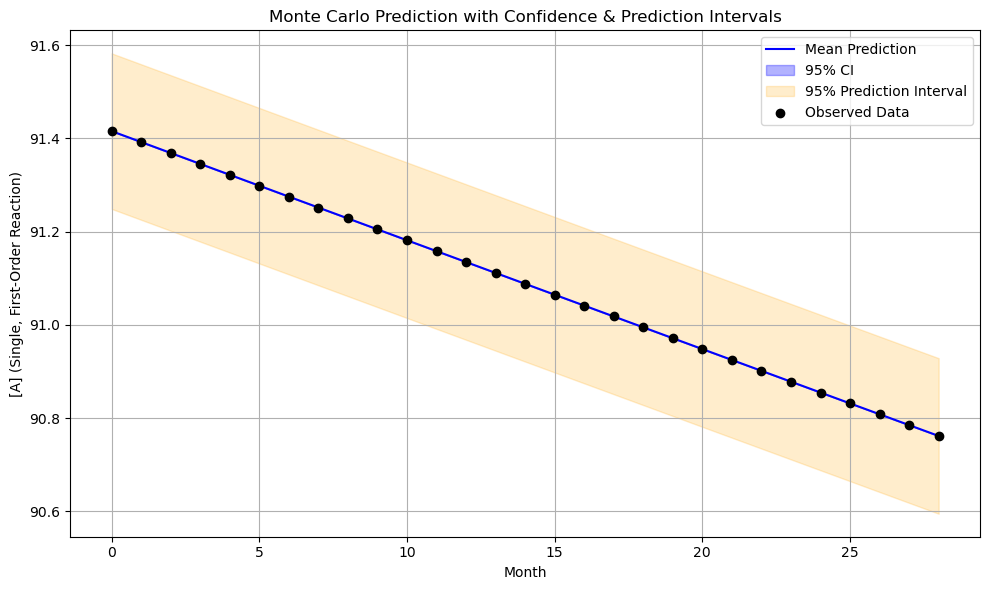

In [17]:
months = np.arange(N_MONTHS)

plt.figure(figsize=(10, 6))
plt.plot(months, np.array(mean_pred_A)[0], label='Mean Prediction', color='blue')
plt.fill_between(months, ci_lower_A[0], ci_upper_A[0], color='blue', alpha=0.3, label='95% CI')
plt.fill_between(months, pi_lower_A[0], pi_upper_A[0], color='orange', alpha=0.2, label='95% Prediction Interval')

plt.scatter(months, preds_A, color='black', label='Observed Data', zorder=5)
plt.xlabel("Month")
plt.ylabel("[A] (Single, First-Order Reaction)")
plt.title("Monte Carlo Prediction with Confidence & Prediction Intervals")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

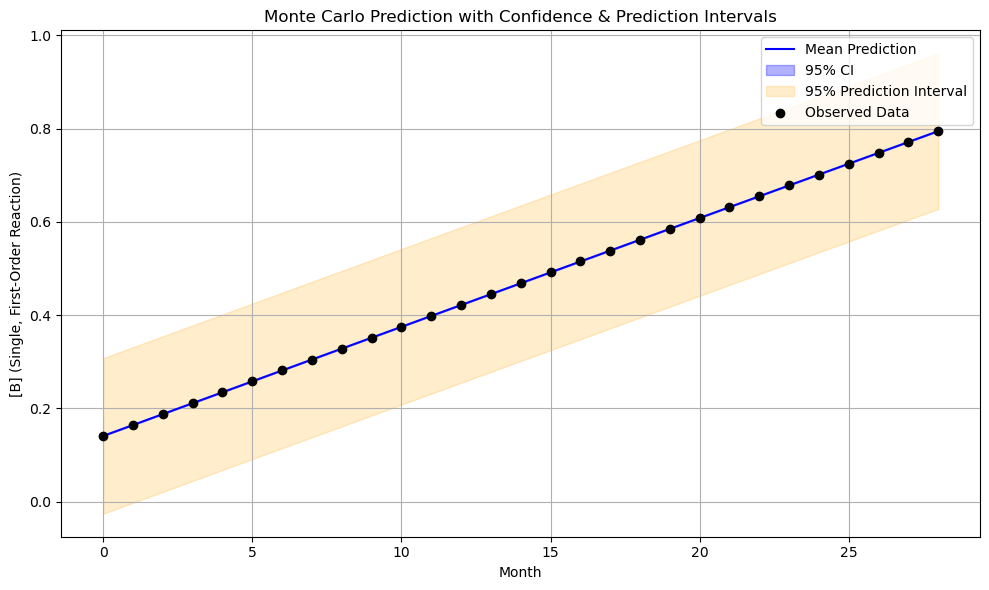

In [18]:
months = np.arange(N_MONTHS)

plt.figure(figsize=(10, 6))
plt.plot(months, np.array(mean_pred_B)[0], label='Mean Prediction', color='blue')
plt.fill_between(months, ci_lower_B[0], ci_upper_B[0], color='blue', alpha=0.3, label='95% CI')
plt.fill_between(months, pi_lower_B[0], pi_upper_B[0], color='orange', alpha=0.2, label='95% Prediction Interval')

plt.scatter(months, preds_B, color='black', label='Observed Data', zorder=5)
plt.xlabel("Month")
plt.ylabel("[B] (Single, First-Order Reaction)")
plt.title("Monte Carlo Prediction with Confidence & Prediction Intervals")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()